# 3. Categorical Mixture Model + Gibbs Sampling Algorithm

In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

import sys
print(sys.version)

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


## 1. Hyperparameters


In [2]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [3]:
df = pd.read_csv('../data/tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [4]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

        
print('N: {} I: {}'.format(N, I))

N: 5568 I: 120


## Exercise 2
Implement the three algorithms in the boxes below (or in a separated python file that can be imported).

### Exercise 2.1: Algorithm 1

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

from log_likelihoods import log_likelihood_zn_theta, log_likelihood_pi_theta
from posteriors import posterior_zn
from utility import exp_normalize, prepare_plot, random_choice_vectorized

In [9]:
def sample_pi(Z, cluster_counts, alpha):
    """
    Samples the mixing coefficients from the posterior P(Pi | Z).
    
    Arguments:
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
        cluster_counts: np.ndarray (K), cluster_counts[i] is the number of
            documents in the i-th cluster
        alpha: np.ndarray (K), parameter for the prior distribution of Pi
    Returns:
        Pi_new: np.ndarray (K), sampled mixing coefficients 
    """
    alpha_new = alpha + cluster_counts 
    return np.random.dirichlet(alpha_new, size=1)[0]

In [10]:
def sample_theta_k(X_matrix, Z, gamma, k):
    """
    Samples cluster parameters Theta_k from the posterior P(Theta_k | X, Z).
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        k: integer, cluster id
    
    Returns:
        Theta_k: np.ndarray (I), contains the parameters of the k-th
            cluster
    """
    # compute the number of occurances for each word in cluster k
    word_cluster_counts = X_matrix[np.where(Z == k), :].sum(axis=1)[0]
    gamma_new = gamma + word_cluster_counts
    return np.random.dirichlet(gamma_new, size=1)[0]    

In [11]:
def sample_z(post_z):
    """
    Samples the cluster assignment z_n of x_n from the posterior 
    P(z_n | x_n, Pi, Theta) for all N.
    
    Arguments:
        post_z: np.ndarray, (N x K), post_z[i, j] represents
            p(z_i = j | x_i, Pi, Theta)
    Returns:
        Z: integer, sampled cluster assignments of X
    """
    return random_choice_vectorized(post_z) 

In [12]:
def log_likelihood(log_lik_zn_theta, Z, Pi=None):
    """
    Computes the log-likelihood logP(X | Z, Theta)
    
    Arguments:
        log_lik_zn_theta: np.ndarray, (N x K), lik_zn_theta[i, j] represents
            logP(x_i | z_i = j, Theta) 
        Pi: np.ndarray (K), mixing coefficients
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
    
    Returns:
        log_likelihood: float, represents logP(X | Z, Theta) 
    """
    
    summands = log_lik_zn_theta # (N x K)
    #summands = log_likelihood_pi_theta(log_lik_zn_theta, Pi)
    summands = summands[np.arange(N), Z] # (N)#[Z] 
    return summands.sum()

In [35]:
def gibbs_1(X_matrix, K, alpha, I, gamma, burnin, stop=False):
    """
    Approximates the posterior distribution p(Pi, Z, Theta | X) via   
    Gibbs sampling.
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        K: integer, number of clusters
        alpha: np.ndarray (K), parameter for the prior distribution
            of Pi
        I: integer, length of the dictionary
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        burnin: integer, number of iterations
        stop: bool, if stop=True, the algorithm will terminate when
            the log-likelihood has not improved for 10 iterations
    Returns:

    """
    # number of documents
    N, _ = X_matrix.shape
    
    cluster_counts = np.zeros(K, dtype=np.int)

    # prepare likelihood plot animation
    lik, fig, ax, line, bar, bar_ordered = prepare_plot(K, N)
    
    def animate(i):
        line.axes.set_xlim(0, i)
        line.axes.set_ylim(0.9 * np.min(lik), 1.1 * np.max(lik))
        line.axes.invert_yaxis()
        line.set_data(np.arange(i), lik[:i])
        
        for i, b in enumerate(bar):
            b.set_height(cluster_counts[i])
        
        ccounts_ordered = np.sort(cluster_counts)
        for i, b in enumerate(bar_ordered):
            b.set_height(ccounts_ordered[i])
         
    # sample mixing coefficients from prior
    Pi = np.random.dirichlet(alpha, size=1)[0] # K
    
    # sample Theta from prior
    Theta = np.random.dirichlet(gamma, size=K) # K x I
    
    # sample Z from prior
    Z = np.zeros((burnin + 1, N), dtype=np.int)
    Z[0, :] = np.random.choice(np.arange(K), size=N, p=Pi) # N

    cluster, counts = np.unique(Z[0, :], return_counts=True)  
    cluster_counts[cluster] = counts
    
    for step in range(burnin):
        
        # sample mixing coefficients Pi  from posterior
        Pi = sample_pi(Z[step], cluster_counts, alpha) # K
        
        for k in range(K):

            # sample cluster parameters theta_k from posterior
            Theta[k] = sample_theta_k(X_matrix, Z[step], gamma, k) # I
                    
        # compute p(xn | zn=k, Theta) for all n and all k
        log_lik_zn_theta = log_likelihood_zn_theta(X_matrix, Theta)
        
        # compute p(xn | Pi, Theta) for all n
        log_lik_pi_theta = log_likelihood_pi_theta(log_lik_zn_theta, Pi)
        
        # compute p(zn =  k | xn, Pi, Theta) for all n and all k
        post_z = posterior_zn(Pi, log_lik_zn_theta, log_lik_pi_theta) # N x K
        
        # sample cluster assignments Z
        Z[step + 1, :] = sample_z(post_z)
        
        cluster_counts = np.zeros(K, dtype=np.int)
        cluster, counts = np.unique(Z[step + 1], return_counts=True)  
        cluster_counts[cluster] = counts        
        
        lik.append(log_likelihood(log_lik_zn_theta, Z[step + 1], Pi))
        
        # stop if log-likelihood converged
        if stop and step >= 10:
            if np.all(lik[step-9:] <= lik[step-10]):
                break

        if (step) % 10 == 0:
            # plot likelihood
            animate(step)
            clear_output(wait=True)
            display(fig)
            plt.show()
            print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]}")
        
    # plot likelihood
    animate(step)
    clear_output(wait=True)
    display(fig)
    plt.show()
    print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]}")
            
    return Pi, Theta, Z, lik

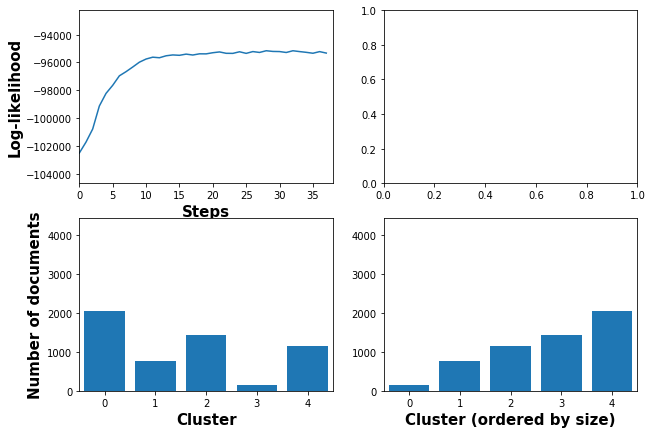

Iteration: 38 	 Log-likelihood: -95277.88592861734


In [36]:
alpha = np.ones(K)
gamma = np.ones(I)
burnin = 100
Pi, Theta, Z, lik_1 = gibbs_1(X_matrix, K, alpha, I, gamma, burnin, True)

### Exercise 2.1: Algorithm 2

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

from posteriors import log_posterior_z_minus_n, posterior_zn_2

In [37]:
def gibbs_2(X_matrix, K, alpha, I, gamma, burnin, stop=False):
    """
    Approximates the posterior distribution p(Z, Theta | X) via   
    (collapsed) Gibbs sampling.
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        K: integer, number of clusters
        alpha: np.ndarray (K), parameter for the prior distribution
            of Pi
        I: integer, length of the dictionary
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        burnin: integer, number of iterations
        stop: bool, if stop=True, the algorithm will terminate when
            the log-likelihood has not improved for 10 iterations
    Returns:
    
    """
    # number of documents
    N, _ = X_matrix.shape
    
    # prepare likelihood plot animation
    lik, fig, ax, line, bar, bar_ordered = prepare_plot(K, N)
    
    def animate(i):
        line.axes.set_xlim(0, i)
        line.axes.set_ylim(0.9 * np.min(lik), 1.1 * np.max(lik))
        line.axes.invert_yaxis()
        line.set_data(np.arange(i), lik[:i])
        
        for i, b in enumerate(bar):
            b.set_height(cluster_counts[i])
        
        ccounts_ordered = np.sort(cluster_counts)
        for i, b in enumerate(bar_ordered):
            b.set_height(ccounts_ordered[i])
    
    # sample mixing coefficients Pi from prior
    Pi = np.random.dirichlet(alpha, size=1)[0] # K
    
    # sample Theta from prior
    Theta = np.random.dirichlet(gamma, size=K) # K x I
    
    # sample Z from prior
    Z = np.zeros((burnin + 1, N), dtype=np.int)
    Z[0, :] = np.random.choice(np.arange(K), size=N, p=Pi) # N
    
    cluster_counts = np.zeros(K, dtype=np.int)
    cluster, counts = np.unique(Z[0], return_counts=True)  
    cluster_counts[cluster] = counts
    
    for step in range(burnin):
        
        for k in range(K):
            
            # sample likelihood parameters Theta_k
            Theta[k] = sample_theta_k(X_matrix, Z[step], gamma, k) # I
        
        # compute logP(x_n | z_n = k, Theta)
        log_lik_zn_theta = log_likelihood_zn_theta(X_matrix, Theta) # N x K 
        
        # compute logP(z_n | Z_minus_n)
        log_post_z_minus_n = log_posterior_z_minus_n(Z[step], alpha, cluster_counts) # N x K
        
        # compute P(z_n = k | x_n, Z_minus_n, Theta)
        post_zn_2 = posterior_zn_2(log_lik_zn_theta, log_post_z_minus_n) # N x K
        
        # sample cluster assignment z_n
        Z[step + 1, :] = sample_z(post_zn_2)

        cluster_counts = np.zeros(K, dtype=np.int)
        cluster, counts = np.unique(Z[step + 1], return_counts=True)  
        cluster_counts[cluster] = counts
        
        lik.append(log_likelihood(log_lik_zn_theta, Z[step + 1]))
        
        # stop if log-likelihood converged
        if stop and step >= 10:
            if np.all(lik[step-9:] <= lik[step-10]):
                break
                
        if (step) % 10 == 0:
            # plot likelihood
            animate(step)
            clear_output(wait=True)
            display(fig)
            plt.show()
            print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]}")
        
    # plot likelihood
    animate(step)
    clear_output(wait=True)
    display(fig)
    plt.show()
    print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]}")
    return Theta, Z, lik

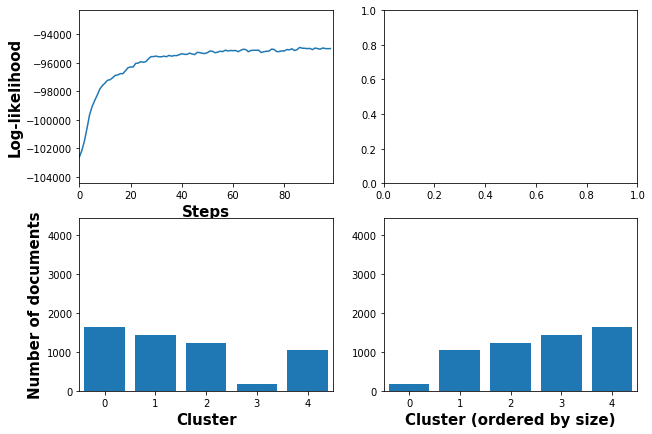

Iteration: 99 	 Log-likelihood: -95126.63260452676


In [38]:
alpha = np.ones(K)
gamma = np.ones(I)
burnin = 100
Theta, Z, lik_2 = gibbs_2(X_matrix, K, alpha, I, gamma, burnin)

### Exercise 2.1: Algorithm 3

In [45]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

from log_likelihoods import log_likelihood_zn_Xmn_Zmn
from posteriors import posterior_zn_3

In [46]:
def sample_z_3(post_zn_3):
    """
    Samples the cluster assignment z_n of x_n from the posterior 
    P(z_n = k | X, Z_-n).

    Arguments:
        post_zn_3: np.ndarray, (K), post_zn_3[j] represents
            p(z_n = j | X, Z_minus_n)  
        
    Returns:
        z_n: integer, sampled cluster assignment of x_n
    """
    
    K = len(post_zn_3)
    
    return np.random.choice(np.arange(K), p=post_zn_3)

In [47]:
def log_likelihood_3(log_lik_zn_Xmn_Z_mn, Z):
    """
    Computes the log-likelihood logP(X | Z, X_minus_n)
    
    Arguments:
        log_lik_zn_Xmn_Zmn: np.ndarray, (K), lik_zn_Xmn_Zmn[i] represents
            logP(x_n | z_n = j, X_minus_n, Z_minus_n) 
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
    
    Returns:
        log_likelihood: float, represents logP(X | Z, X_minus_n) 
    """
    
    summands = log_lik_zn_Xmn_Zmn # (N x K)
    summands = summands[np.arange(N), Z] # (N)
    return summands.sum()

In [50]:
import time 
Let consider the log-likelihood as the measure of convergence andK=5.  For each of thethree Gibbs samplers, show the evolution of the log-likelihood per iteration until convergence.
def gibbs_3(X_matrix, K, alpha, I, gamma, burnin, stop):
    """
    Approximates the posterior distribution p(Z | X) via
    (collapsed) Gibbs sampling.
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        K: integer, number of clusters
        alpha: np.ndarray (K), parameter for the prior distribution
            of Pi
        I: integer, length of the dictionary
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        burnin: integer, number of iterations
        stop: bool, if stop=True, the algorithm will terminate when
            the log-likelihood has not improved for 10 iterations
        
    Returns:
    """
    # number of documents
    N, _ = X_matrix.shape
    
    # prepare likelihood plot animation
    lik, fig, ax, line, bar, bar_ordered = prepare_plot(K, N)
    
    def animate(i):
        line.axes.set_xlim(0, i)
        line.axes.set_ylim(0.9 * np.min(lik), 1.1 * np.max(lik))
        line.axes.invert_yaxis()
        line.set_data(np.arange(i), lik[:i])
        
        for i, b in enumerate(bar):
            b.set_height(cluster_counts[i])
        
        ccounts_ordered = np.sort(cluster_counts)
        for i, b in enumerate(bar_ordered):
            b.set_height(ccounts_ordered[i])
    
    # sample mixing coefficients Pi from prior
    Pi = np.random.dirichlet(alpha, size=1)[0] # K
    
    # sample Z from prior
    Z = np.zeros((burnin + 1, N), dtype=np.int)
    Z[0, :] = np.random.choice(np.arange(K), size=N, p=Pi) # N

    cluster_counts = np.zeros(K, dtype=np.int)
    cluster, counts = np.unique(Z[0], return_counts=True)  
    cluster_counts[cluster] = counts
    
    # Teta estimate for likelihood
    Theta = np.zeros((K, I))

    for step in range(burnin):
        tic = time.time()
        # compute logP(z_n | Z_minus_n)
        log_post_z_minus_n = log_posterior_z_minus_n(Z[step], alpha, cluster_counts) # N x K
        
        # compute logP(x_n | z_n = k, X_-n, Z_-n)
        log_lik_zn_Xmn_Zmn = log_likelihood_zn_Xmn_Zmn(X_matrix, Z[step], gamma, K) # N x K
        
        #for n in range(N):
            
        # compute logP(z_n = k | )
        post_zn_3 = posterior_zn_3(log_post_z_minus_n, log_lik_zn_Xmn_Zmn) # K
        
        # sample cluster assignments 
        Z[step + 1] = sample_z(post_zn_3)
        
        cluster_counts = np.zeros(K, dtype=np.int)
        cluster, counts = np.unique(Z[step + 1], return_counts=True)  
        cluster_counts[cluster] = counts            
        
        # compute log_likelihood        
        for k in range(K):
            
            # sample likelihood parameters Theta_k
            Theta[k] = sample_theta_k(X_matrix, Z[step + 1], gamma, k) # I
            
        log_lik_zn_theta = log_likelihood_zn_theta(X_matrix, Theta)
        log_lik = log_likelihood(log_lik_zn_theta, Z[step + 1])
        lik.append(log_lik)
        
        # stop if log-likelihood converged
        if stop and step >= 10:
            if np.all(lik[step-9:] <= lik[step-10]):
                break
                
        toc = time.time()
        if (step) % 10 == 0:
            # plot likelihood
            animate(step)
            clear_output(wait=True)
            display(fig)
            plt.show()
            print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]} \t time:{toc-tic}")
        
    # plot likelihood
    animate(step)
    clear_output(wait=True)
    display(fig)
    plt.show()
    print(f"Iteration: {(step)} \t Log-likelihood: {lik[step]}")
            
    return Z, lik

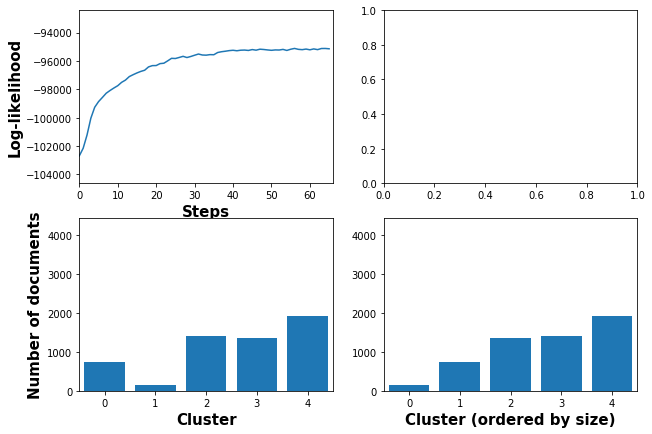

Iteration: 66 	 Log-likelihood: -95171.12248036696


In [51]:
alpha = np.ones(K)
gamma = np.ones(I)
burnin = 100
Z, lik_3 = gibbs_3(X_matrix, K, alpha, I, gamma, burnin, True)

### Exercise 2.2

In [24]:
import numpy

In [25]:
K = 4
alpha = np.ones(K)
gamma = np.ones(I)

burnin_list = [20, 200, 500]
burnin = burnin_list[-1]

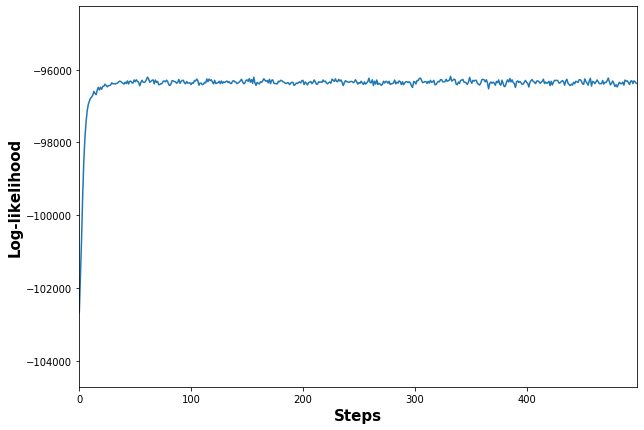

Iteration: 499 	 Log-likelihood: -96343.52365791515


In [26]:
Z = np.zeros((3, burnin + 1, N))
loglik = np.zeros((3, burnin))
        
# Algorithm 1
_, _, Z_1, loglik_1 = gibbs_1(X_matrix, K, alpha, I, gamma, burnin)
Z[0, :] = Z_1
loglik[0, :] = loglik_1
    
# Algorithm 2
_, Z_2, loglik_2 = gibbs_2(X_matrix, K, alpha, I, gamma, burnin)
Z[1, :] = Z_2
loglik[1, :] = loglik_2
    
# Algorithm 3
Z_3, loglik_3 = gibbs_3(X_matrix, K, alpha, I, gamma, burnin)
Z[2, :] = Z_3
loglik[2, :] = loglik_3
    
np.save(f"ex_2_Z", Z)
np.save(f"ex_2_loglik", loglik)

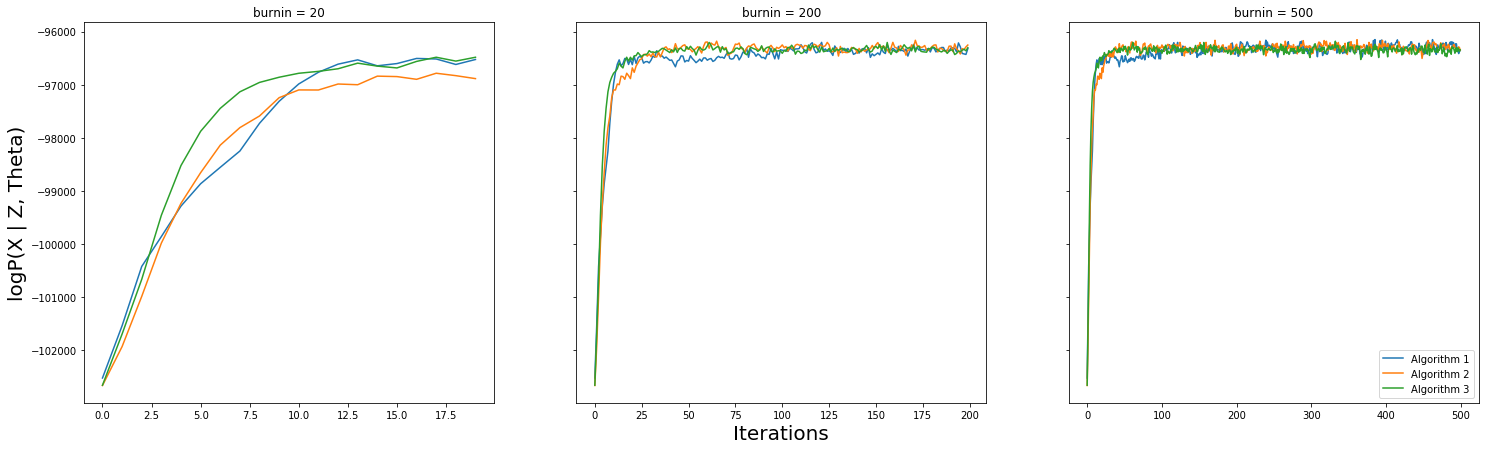

In [27]:
fig, ax = plt.subplots(1, len(burnin_list), figsize=(25,7), sharey=True)
ax[1].set_xlabel("Iterations", fontsize=20)
ax[0].set_ylabel("logP(X | Z, Theta)", fontsize=20)

loglik = np.load(f"ex_2_loglik.npy")

for i, burnin in enumerate(burnin_list):
    
    ax[i].set_title(f"burnin = {burnin}")
    
    ax[i].plot(np.arange(burnin), loglik[0, :burnin], color="C0", label="Algorithm 1")
    ax[i].plot(np.arange(burnin), loglik[1, :burnin], color="C1", label="Algorithm 2")
    ax[i].plot(np.arange(burnin), loglik[2, :burnin], color="C2", label="Algorithm 3")

plt.legend()
plt.show()

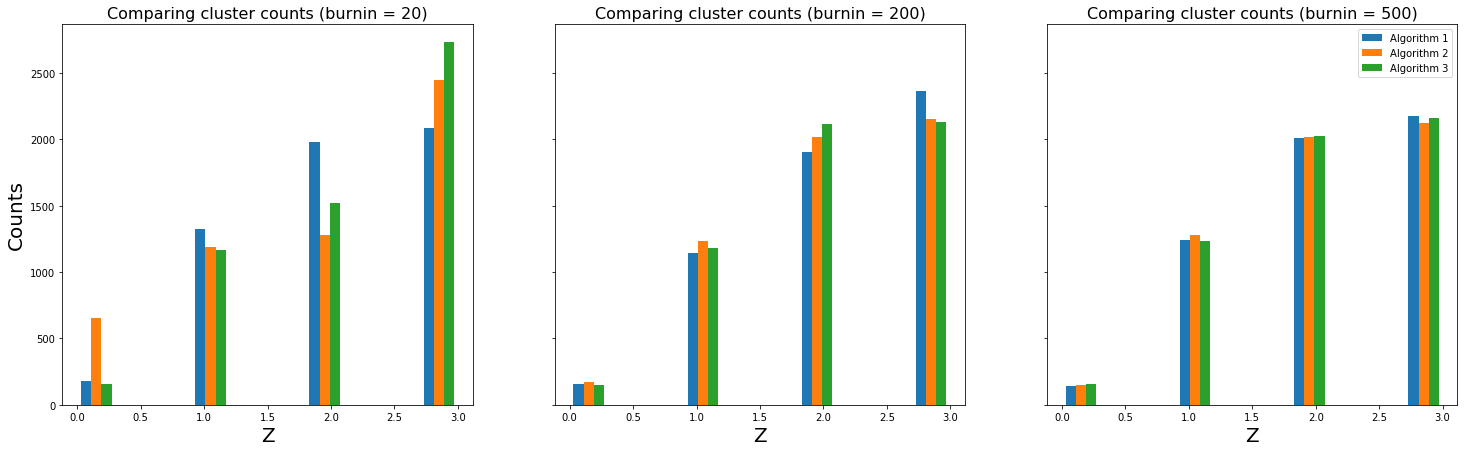

In [28]:
fig, ax = plt.subplots(1, len(burnin_list), figsize=(25,7), sharey=True)

ax[0].set_ylabel("Counts", fontsize=20)

Z = np.load(f"ex_2_Z.npy")

for i, burnin in enumerate(burnin_list):
    
    cluster_0, cluster_counts_0 = np.unique(Z[0, burnin, :], return_counts=True)
    cluster_1, cluster_counts_1 = np.unique(Z[1, burnin, :], return_counts=True)
    cluster_2, cluster_counts_2 = np.unique(Z[2, burnin, :], return_counts=True)
    
    sort_0 = np.argsort(cluster_counts_0)
    sort_1 = np.argsort(cluster_counts_1)
    sort_2 = np.argsort(cluster_counts_2)

    Z[0, burnin, :] = [np.where(sort_0 == int(k))[0] for k in Z[0, burnin, :]]
    Z[1, burnin, :] = [np.where(sort_1 == int(k))[0] for k in Z[1, burnin, :]]
    Z[2, burnin, :] = [np.where(sort_2 == int(k))[0] for k in Z[2, burnin, :]]
    
    ax[i].set_title(f"Comparing cluster counts (burnin = {burnin})", fontsize=16)
    ax[i].hist([Z[0, burnin, :], Z[1, burnin, :], Z[2, burnin, :]], label=["Algorithm 1", "Algorithm 2", "Algorithm 3"])
    ax[i].set_xlabel("Z", fontsize=20)
    
plt.legend()

plt.show()

### Exercise 2.3
Some useful packages:
- matplotlib https://matplotlib.org/
- seaborn https://github.com/mwaskom/seaborn
- wordcloud https://github.com/amueller/word_cloud
- probvis https://github.com/psanch21/prob-visualize

In [53]:
"""
Let consider the log-likelihood as the measure of convergence and K=5. For each of thethree Gibbs samplers, 
show the evolution of the log-likelihood per iteration until convergence.Let consider the log-likelihood as the measure of convergence and K=5.  
For each of thethree Gibbs samplers, show the evolution of the log-likelihood per iteration until convergence.
"""

K = 5

# prior parameters
alpha = np.ones(K)
gamma = np.ones(I)

# stop at convergence of log-likelihood
burnin = 10000
stop = True

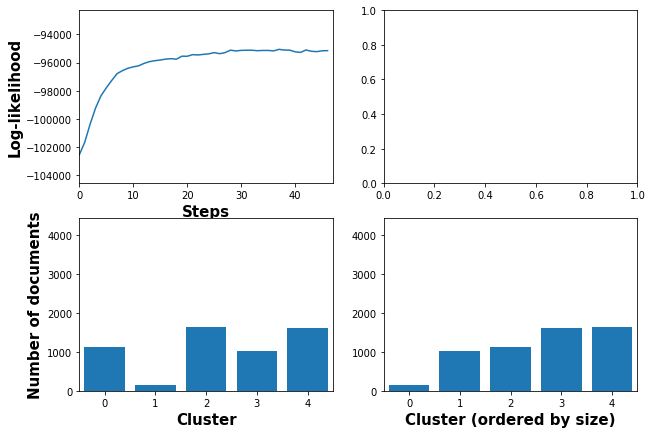

Iteration: 47 	 Log-likelihood: -95116.14188808779


In [57]:
"""
Run Algorithm 1 until convergence.
"""
Pi_1, Theta_1, Z_1, lik_1 = gibbs_1(X_matrix, K, alpha, I, gamma, burnin, stop)

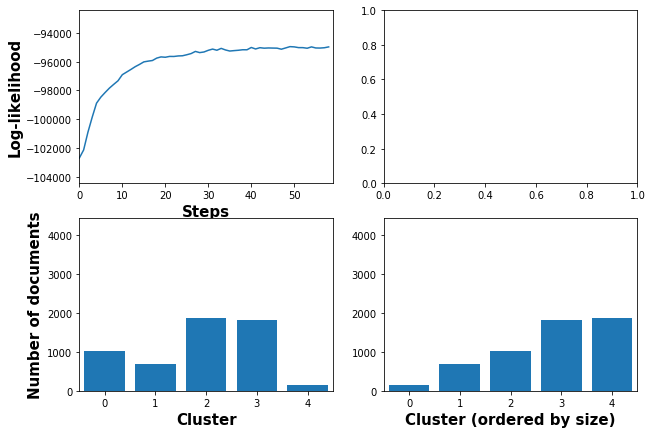

Iteration: 59 	 Log-likelihood: -95049.89508032327


In [59]:
"""
Run Algorithm 2 until convergence.
"""
Theta_2, Z_2, lik_2 = gibbs_2(X_matrix, K, alpha, I, gamma, burnin, stop)

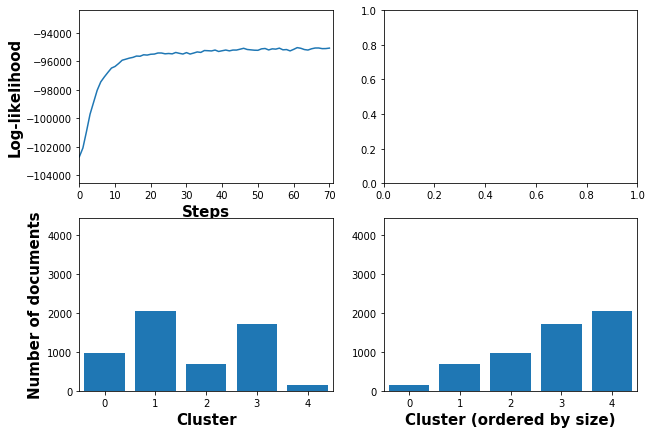

Iteration: 71 	 Log-likelihood: -95074.90927774335


In [60]:
"""
Run Algorithm 3 until convergence.
"""
Z_3, lik_3 = gibbs_3(X_matrix, K, alpha, I, gamma, burnin, stop)

In [62]:
"""
Then, take a sample from all the hidden variables after convergence and show: 

i) the 10 mostrepresentative words for each topic using a cloud of words 

ii) the 10 most relevant documents for each topic
"""
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

tweet_array = np.array(df_data['tweet'].values)

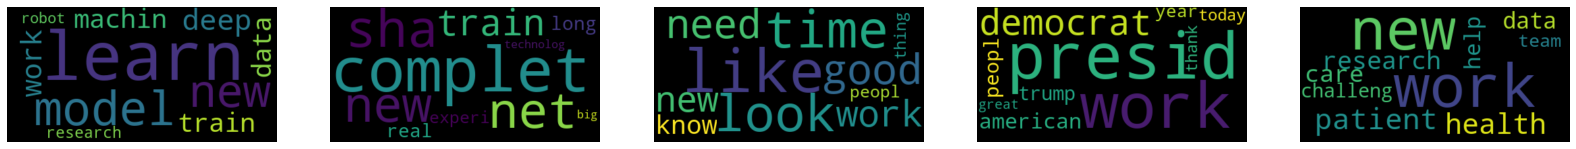

In [63]:
"""
Algorithm 1 - most representative words for each cluster
"""
fig, ax = plt.subplots(1, K, figsize=(28,15))

for k in range(K):
    theta_k = Theta_1[k]
    
    # get indices of 10 most representative words
    ind = np.argsort(theta_k)[-10:]
    
    words = [dictionary[i] for i in ind]     
    frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
    
    # generate wordcloud
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")

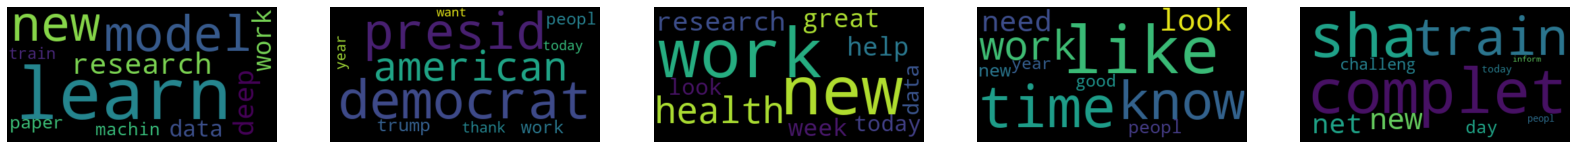

In [64]:
"""
Algorithm 2 - most representative words for each cluster
"""
fig, ax = plt.subplots(1, K, figsize=(28,15))

for k in range(K):
    theta_k = Theta_2[k]
    
    # get indices of 10 most representative words
    ind = np.argsort(theta_k)[-10:]
    
    words = [dictionary[i] for i in ind]     
    frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
    
    # generate wordcloud
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")

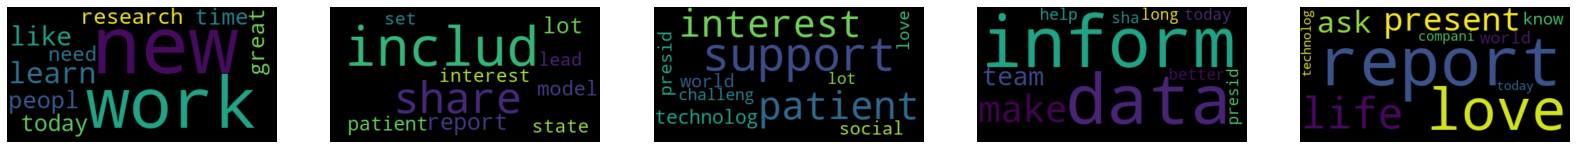

In [65]:
"""
Algorithm 3 - most representative words for each cluster
"""
fig, ax = plt.subplots(1, K, figsize=(28,15))

for k in range(K):
    theta_k = sample_theta_k(X_matrix, Z_3[-1], gamma, k)
    
    # get indices of 10 most representative words
    ind = np.argsort(theta_k)[-10:]
    
    words = [dictionary[i] for i in ind]     
    frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
    
    # generate wordcloud
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")

In [66]:
"""
Algorithm 1 - most relevant document for each topic
"""
log_lik_zn_theta_1 = log_likelihood_zn_theta(X_matrix, Theta_1)

for k in range(K):
    
    # get indices of 10 most relevant documents
    ind = np.argsort(log_lik_zn_theta_1[:, k])[-10:]
    
    for i, idx in enumerate(ind):
        print(f"\nCluster {k} \t tweet {i+1}:")
        print(tweet_array[idx])


Cluster 0 	 tweet 1:
ADMM for Efficient Deep Learning with Global Convergence https://www.reddit.com/r/MachineLearning/comments/cuod19/admm_for_efficient_deep_learning_with_global/ …

Cluster 0 	 tweet 2:
Packed tent for @nxthompson's chat with deep learning pioneer @geoffreyhinton at #GoogleIO2019 Livestream:  https://youtu.be/RKvqR1kUQD4  pic.twitter.com/9AavPxroK7

Cluster 0 	 tweet 3:
UC Berkeley's CS 285: Deep Reinforcement Learning https://www.reddit.com/r/MachineLearning/comments/db8c4u/n_uc_berkeleys_cs_285_deep_reinforcement_learning/ …

Cluster 0 	 tweet 4:
Deep learning without back-propagation https://www.reddit.com/r/MachineLearning/comments/cql2yr/deep_learning_without_backpropagation/ …

Cluster 0 	 tweet 5:
HGX-2 Deep Learning Benchmarks: The 81,920 CUDA Core “Behemoth” GPU Server https://www.reddit.com/r/MachineLearning/comments/crakhv/n_hgx2_deep_learning_benchmarks_the_81920_cuda/ …

Cluster 0 	 tweet 6:
New BAIR blog by Eric Liang, Richard Liaw & Clement Gehring de

In [67]:
"""
Algorithm 2 - most relevant document for each topic
"""
log_lik_zn_theta_2 = log_likelihood_zn_theta(X_matrix, Theta_2)

for k in range(K):
    
    # get indices of 10 most relevant documents
    ind = np.argsort(log_lik_zn_theta_2[:, k])[-10:]
    
    for i, idx in enumerate(ind):
        print(f"\nCluster {k} \t tweet {i+1}:")
        print(tweet_array[idx])


Cluster 0 	 tweet 1:
HGX-2 Deep Learning Benchmarks: The 81,920 CUDA Core “Behemoth” GPU Server https://www.reddit.com/r/MachineLearning/comments/crakhv/n_hgx2_deep_learning_benchmarks_the_81920_cuda/ …

Cluster 0 	 tweet 2:
Deep learning without back-propagation https://www.reddit.com/r/MachineLearning/comments/cql2yr/deep_learning_without_backpropagation/ …

Cluster 0 	 tweet 3:
Deep learning can decode neural activity to predict a mouse's location https://www.reddit.com/r/MachineLearning/comments/cqcf34/p_deep_learning_can_decode_neural_activity_to/ …

Cluster 0 	 tweet 4:
UC Berkeley's CS 285: Deep Reinforcement Learning https://www.reddit.com/r/MachineLearning/comments/db8c4u/n_uc_berkeleys_cs_285_deep_reinforcement_learning/ …

Cluster 0 	 tweet 5:
Is transfer learning still worth entering into as a researcher? https://www.reddit.com/r/MachineLearning/comments/d23qm0/d_is_transfer_learning_still_worth_entering_into/ …

Cluster 0 	 tweet 6:
Learning a new language can be a daunti

In [68]:
"""
Algorithm 3 - most relevant document for each topic
"""
# sample Theta_3 using Z_3
Theta_3 = np.zeros((K, I))

for k in range(K):
    Theta_3[k] = sample_theta_k(X_matrix, Z_3[-1], gamma, k)

log_lik_zn_theta_3 = log_likelihood_zn_theta(X_matrix, Theta_3)

for k in range(K):
    
    # get indices of 10 most relevant documents
    ind = np.argsort(log_lik_zn_theta_3[:, k])[-10:]
    
    for i, idx in enumerate(ind):
        print(f"\nCluster {k} \t tweet {i+1}:")
        print(tweet_array[idx])


Cluster 0 	 tweet 1:
I'm reminded of the Toni Morrison quote: “The function, the very serious function of [Trumpism] is distraction. It keeps you from doing your work. It keeps you explaining, over and over again, your reason for [something sensible, like not killing off species]." pic.twitter.com/I9g75hb12v

Cluster 0 	 tweet 2:
I'm like Cinderella at midnight except at 4 PM on a Friday when I lose all my magic but then refuse to do any work or chores or really anything. #tgif

Cluster 0 	 tweet 3:
Everything old is new again...or something like that. pic.twitter.com/VHaAyb0mgl

Cluster 0 	 tweet 4:
Congratulations to @neuro_kim who is featured in @techreview’s #35InnovatorsUnder35 list for her work on biological reinforcement learning and the hippocampal formation  https://www.technologyreview.com/lists/innovators-under-35/2019/visionary/kimberly-stachenfeld/ … pic.twitter.com/2p1SURb7U6

Cluster 0 	 tweet 5:
If you are working on imitation learning, inverse RL, or related topics, c